In [1]:
%pip install numpy pandas scikit-learn nltk matplotlib seaborn xgboost catboost wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [ ]:
import kagglehub

path = kagglehub.dataset_download("prathamsaraf1389/top-100-reddit-posts-daily-update")

print("Path to dataset files:", path)

100%|██████████| 391M/391M [00:11<00:00, 36.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prathamsaraf1389/top-100-reddit-posts-daily-update/versions/174


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/prathamsaraf1389/top-100-reddit-posts-daily-update/versions/174 /content


In [ ]:
import pandas as pd

df = pd.read_csv('/content/174/top_reddit_posts.csv')

print(df.head())

   Unnamed: 0                                              Title  \
0           0  What's the worst possible reply to "I'm pregna...   
1           1  People who work at super fancy hotels, what ki...   
2           2                      People who have 4+ kids, why?   
3           3  What's the most fucked up drama from somewhere...   
4           4  If your partner came home and told you they ac...   

                Author  Subreddit  Score  \
0        EmmanuelMoyta  AskReddit  15601   
1      akumamatata8080  AskReddit  12789   
2           GabesterMc  AskReddit  11689   
3      GransShortbread  AskReddit   8814   
4  Alternative-Cod8891  AskReddit   4876   

                                           Permalink  Creation Time  \
0  /r/AskReddit/comments/14cmu88/whats_the_worst_...   1.687101e+09   
1  /r/AskReddit/comments/14cztbf/people_who_work_...   1.687135e+09   
2  /r/AskReddit/comments/14cqute/people_who_have_...   1.687111e+09   
3  /r/AskReddit/comments/14coqqm/whats_the

In [ ]:
columns_to_drop = [
    'Unnamed: 0',
    'Subreddit',
    'Permalink',
    'URL',
    'Post ID',
    'Is Original Content',
    'Flair',
    'Upvote Ratio',
    'Creation Time',
    'Comments'
]

df_clean = df.drop(columns=columns_to_drop)
print(df_clean.head())

                                               Title               Author  \
0  What's the worst possible reply to "I'm pregna...        EmmanuelMoyta   
1  People who work at super fancy hotels, what ki...      akumamatata8080   
2                      People who have 4+ kids, why?           GabesterMc   
3  What's the most fucked up drama from somewhere...      GransShortbread   
4  If your partner came home and told you they ac...  Alternative-Cod8891   

   Score  Number of Comments  
0  15601               15474  
1  12789                3340  
2  11689                4457  
3   8814                3889  
4   4876                2422  


In [ ]:
print("Размер DataFrame (строк, столбцов):", df_clean.shape)

Размер DataFrame (строк, столбцов): (17272, 4)


In [ ]:
!pip install wordcloud

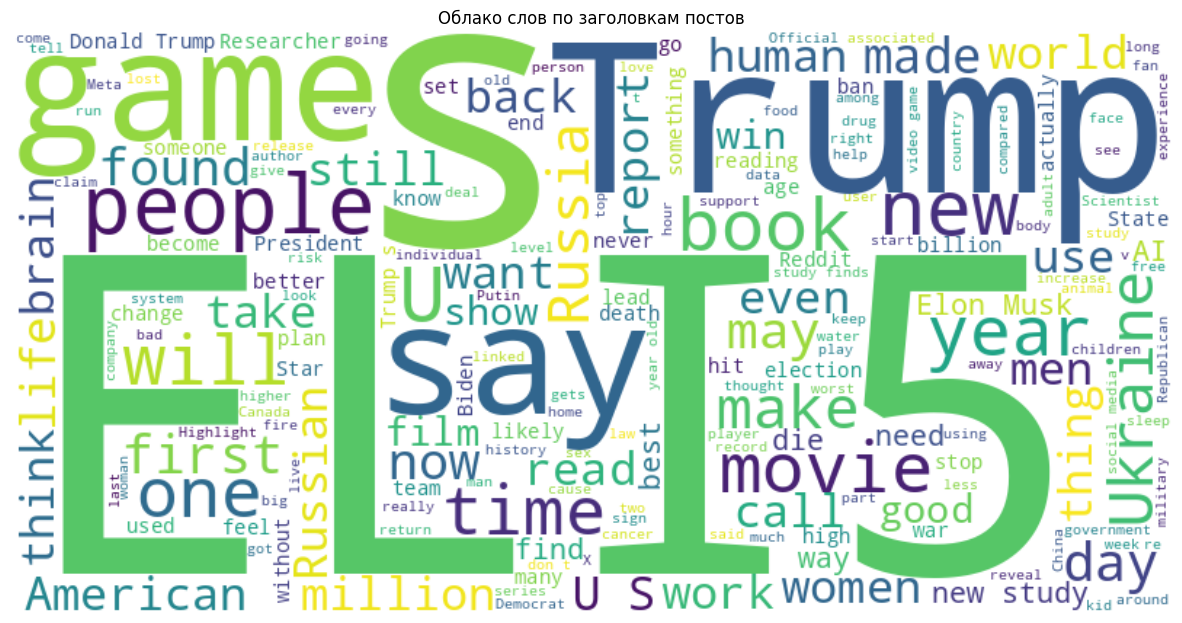

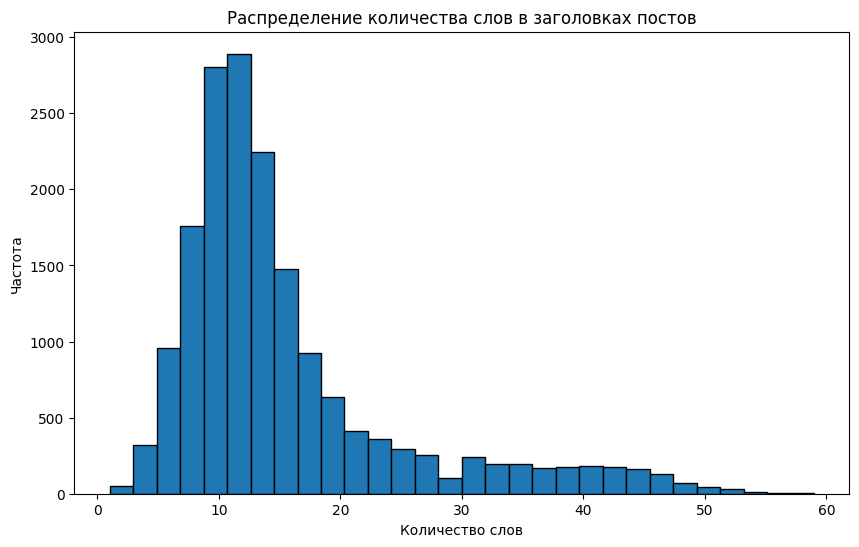

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Если в столбце 'Title' могут быть нестроковые значения, отфильтруем их:
text = " ".join(title for title in df['Title'] if isinstance(title, str))

# Создаем облако слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Облако слов по заголовкам постов")
plt.show()

# Анализ распределения количества слов в заголовках
df_clean['word_count'] = df_clean['Title'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(10,6))
plt.hist(df_clean['word_count'], bins=30, edgecolor='black')
plt.title('Распределение количества слов в заголовках постов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление знаков препинания и лишних символов
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление чисел
    text = re.sub(r'\d+', '', text)
    # Токенизация
    tokens = text.split()
    # Фильтрация: удаляем стоп-слова, слова короче 3 символов и применяем лемматизацию
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Применяем функцию к столбцу Title в DataFrame df_clean
df_clean['clean_title'] = df_clean['Title'].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

print(df_clean[['Title', 'clean_title']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                               Title  \
0  What's the worst possible reply to "I'm pregna...   
1  People who work at super fancy hotels, what ki...   
2                      People who have 4+ kids, why?   
3  What's the most fucked up drama from somewhere...   
4  If your partner came home and told you they ac...   

                                         clean_title  
0                whats worst possible reply pregnant  
1  people work super fancy hotel kind stuff happe...  
2                                         people kid  
3           whats fucked drama somewhere youve lived  
4  partner came home told accidentally murdered s...  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Векторизуем тексты в TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_df=0.5,
    min_df=5,
    max_features=4000
)
X_tfidf = tfidf.fit_transform(df_clean['clean_title'])

# Кластеризуем уже по TF-IDF
optimal_k = 14
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)

# Записываем метки в DataFrame и смотрим распределение
df_clean['cluster'] = clusters
unique, counts = np.unique(clusters, return_counts=True)
print("Размеры кластеров:", dict(zip(unique, counts)))


Размеры кластеров: {np.int32(0): np.int64(200), np.int32(1): np.int64(534), np.int32(2): np.int64(743), np.int32(3): np.int64(1283), np.int32(4): np.int64(8707), np.int32(5): np.int64(813), np.int32(6): np.int64(538), np.int32(7): np.int64(272), np.int32(8): np.int64(1519), np.int32(9): np.int64(198), np.int32(10): np.int64(312), np.int32(11): np.int64(460), np.int32(12): np.int64(1150), np.int32(13): np.int64(543)}


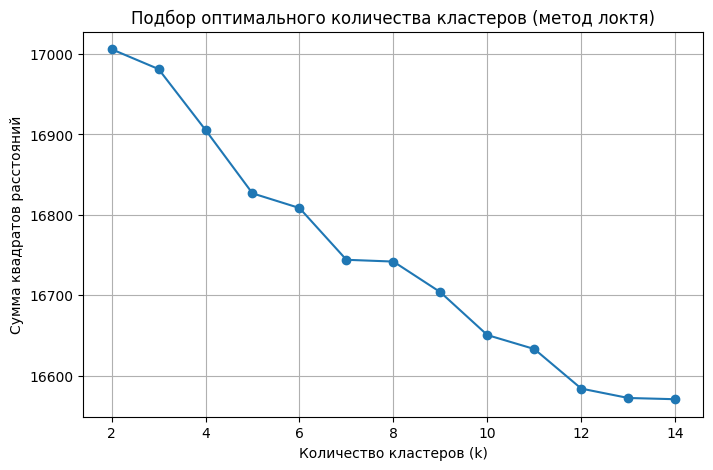

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Подбор оптимального количества кластеров
inertia = []
k_values = range(2, 15)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)

# График метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Подбор оптимального количества кластеров (метод локтя)')
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 14
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)

# Добавим метки кластеров в DataFrame
df_clean['cluster'] = clusters

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Перенумерация кластеров в диапазон от 0 до 13
le = LabelEncoder()
df_clean['cluster_renum'] = le.fit_transform(df_clean['cluster'])
print("Уникальные кластеры:", sorted(df_clean['cluster_renum'].unique()))
print("Сколько их:", df_clean['cluster_renum'].nunique())

Уникальные кластеры: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)]
Сколько их: 14


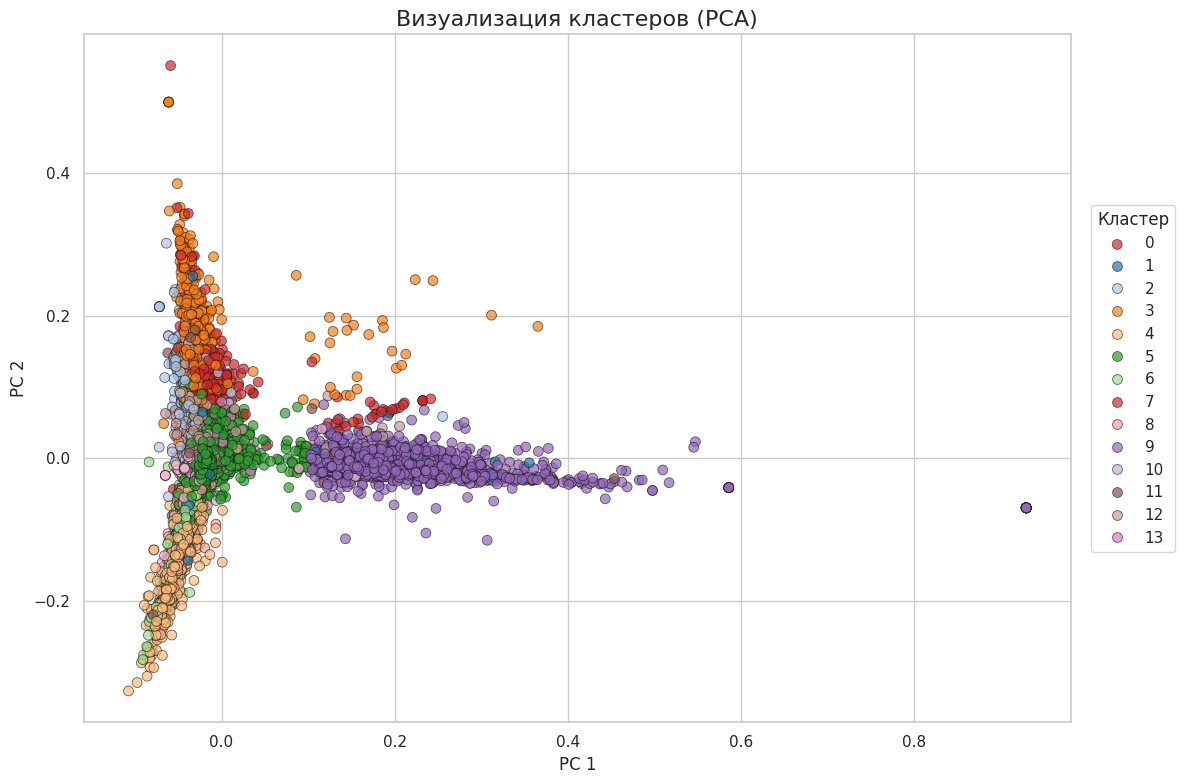

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

# Снижение размерности
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Приведение кластеров к числовому типу и сортировка
df_clean['cluster'] = df_clean['cluster'].astype(int)
sorted_clusters = sorted(df_clean['cluster'].unique())

# Создание DataFrame для визуализации
pca_df = pd.DataFrame({
    'pca1': X_pca[:, 0],
    'pca2': X_pca[:, 1],
    'cluster': df_clean['cluster']
})


palette = sns.color_palette("tab20", len(sorted_clusters))
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(sorted_clusters)}

# Визуализация
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_df,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette=cluster_color_map,
    s=50,
    alpha=0.7,
    edgecolor='k'
)

plt.title("Визуализация кластеров (PCA)", fontsize=16)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(
    title="Кластер",
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
    labels=[str(c) for c in sorted_clusters]
)
plt.tight_layout()
plt.show()


*Анализ* ключевых слов в кластерах (автоматическое назначение тем)



In [ ]:
import numpy as np

def get_top_keywords(tfidf_matrix, clusters, feature_names, n_terms=10):
    df_keywords = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters).mean()
    top_keywords = {}
    for i, row in df_keywords.iterrows():
        top_features = np.argsort(row)[::-1][:n_terms]
        top_keywords[i] = [feature_names[x] for x in top_features]
    return top_keywords

feature_names = tfidf.get_feature_names_out()
top_keywords = get_top_keywords(X_tfidf, clusters, feature_names)

# Выводим топ слов по каждому кластеру
for cluster, keywords in top_keywords.items():
    print(f'Тема {cluster}:', ', '.join(keywords))

Тема 0: without, car, eli, eli car, electric, make, work, would, new, battery
Тема 1: book, read, reading, ever, finish, finish reading, new book, reading week, book start, start finish
Тема 2: game, video game, video, play, year, playing, time, best, steam, first
Тема 3: trump, musk, elon, elon musk, donald trump, donald, say, tariff, president, election
Тема 4: year, say, time, first, official, people, one, would, report, get
Тема 5: ukraine, russia, russian, say, putin, war, north, troop, ukrainian, nato
Тема 6: whats, thing, youve, whats something, something, people, whats worst, ever, someone, worst
Тема 7: tech, big, away, give, isnt, company, big tech, say, passed away, trump
Тема 8: eli, work, get, like, water, people, make, cant, much, dont
Тема 9: film, best, movie, director, studio, best film, festival, david, film festival, award
Тема 10: world, world cup, cup, record, world series, world record, series, first, championship, champion
Тема 11: movie, watched, best, scene, wh

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df_clean['cluster'], test_size=0.2, random_state=42, stratify=df_clean['cluster']
)

print(X_train.shape, X_test.shape)

(13817, 4000) (3455, 4000)


In [ ]:
%pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "CatBoost": CatBoostClassifier(task_type ='GPU', verbose=False, random_seed=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression accuracy: 0.9363
              precision    recall  f1-score   support

           0       1.00      0.28      0.43        40
           1       1.00      0.93      0.97       107
           2       0.98      0.97      0.97       149
           3       0.96      0.98      0.97       257
           4       0.91      1.00      0.95      1742
           5       0.98      0.90      0.94       163
           6       0.96      0.90      0.93       107
           7       0.95      0.37      0.53        54
           8       0.94      0.99      0.96       304
           9       1.00      0.77      0.87        39
          10       0.98      0.85      0.91        62
          11       0.99      0.86      0.92        92
          12       0.96      0.77      0.86       230
          13       0.95      0.79      0.86       109

    accuracy                           0.94      3455
   macro avg       0.97      0.81      0.86      3455
weighted avg       0.94      0.94      0.93

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Linear SVM accuracy: 0.9734
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        40
           1       1.00      1.00      1.00       107
           2       0.97      0.99      0.98       149
           3       0.96      0.98      0.97       257
           4       0.98      0.99      0.98      1742
           5       0.97      0.96      0.97       163
           6       0.96      0.95      0.96       107
           7       0.98      0.76      0.85        54
           8       0.97      1.00      0.98       304
           9       1.00      0.97      0.99        39
          10       0.97      0.95      0.96        62
          11       0.98      0.99      0.98        92
          12       0.94      0.91      0.93       230
          13       0.97      0.89      0.93       109

    accuracy                           0.97      3455
   macro avg       0.97      0.94      0.96      3455
weighted avg       0.97      0.97      0.97      345

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost accuracy: 0.9728
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.98      1.00      0.99       107
           2       0.96      1.00      0.98       149
           3       0.98      0.98      0.98       257
           4       0.98      0.99      0.98      1742
           5       0.97      0.94      0.95       163
           6       0.95      0.92      0.93       107
           7       0.91      0.96      0.94        54
           8       0.99      0.99      0.99       304
           9       0.97      1.00      0.99        39
          10       0.98      0.97      0.98        62
          11       0.97      1.00      0.98        92
          12       0.94      0.87      0.90       230
          13       0.92      0.94      0.93       109

    accuracy                           0.97      3455
   macro avg       0.96      0.96      0.96      3455
weighted avg       0.97      0.97      0.97      3455



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

# Калибровка для SVM (чтобы поддерживал predict_proba)
calibrated_svc = CalibratedClassifierCV(LinearSVC(random_state=42))

# Multinomial Naive Bayes — обучаем на тех же данных
nb = MultinomialNB()

# Ансамбль из 6 моделей (включая Naive Bayes)
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', calibrated_svc),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42)),
        ('cat', CatBoostClassifier(verbose=False, random_seed=42, task_type='GPU')),
        ('nb', nb)
    ],
    voting='soft'
)

# Обучение ансамбля
ensemble.fit(X_train, y_train)

# Прогноз и метрики
y_pred_ensemble = ensemble.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble Voting accuracy: {accuracy_ensemble:.4f}")
print(classification_report(y_test, y_pred_ensemble))


Ensemble Voting accuracy: 0.9777
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        40
           1       0.99      1.00      1.00       107
           2       0.96      1.00      0.98       149
           3       0.97      0.99      0.98       257
           4       0.98      0.99      0.99      1742
           5       0.97      0.96      0.97       163
           6       0.98      0.93      0.95       107
           7       0.98      0.87      0.92        54
           8       0.99      1.00      0.99       304
           9       1.00      1.00      1.00        39
          10       1.00      0.97      0.98        62
          11       0.98      0.99      0.98        92
          12       0.96      0.90      0.93       230
          13       0.96      0.93      0.94       109

    accuracy                           0.98      3455
   macro avg       0.98      0.95      0.97      3455
weighted avg       0.98      0.98      0.98    

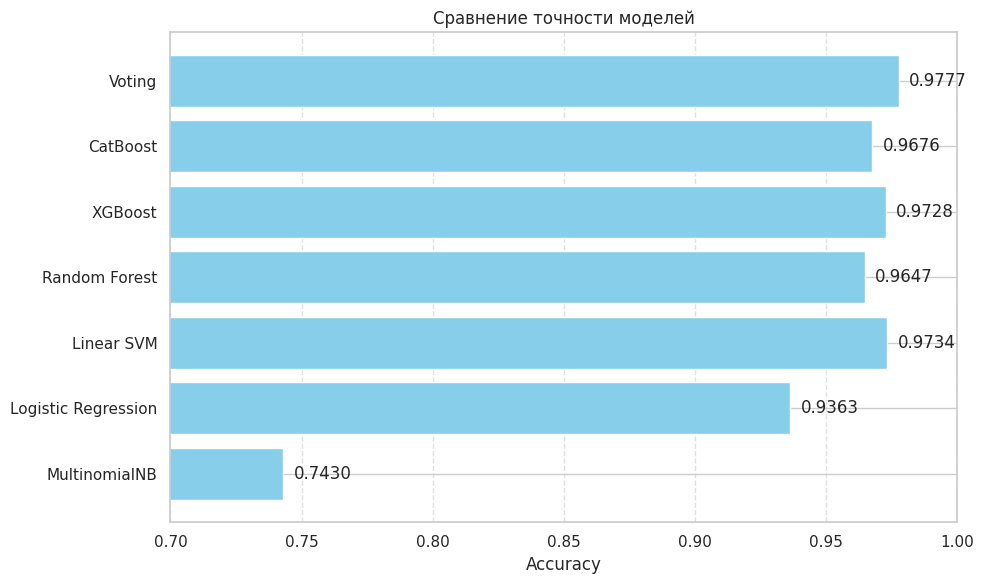

In [ ]:
import matplotlib.pyplot as plt

# Accuracy по результатам из classification_report
model_scores = {
    "MultinomialNB": 0.7430,
    "Logistic Regression": 0.9363,
    "Linear SVM": 0.9734,
    "Random Forest": 0.9647,
    "XGBoost": 0.9728,
    "CatBoost": 0.9676,
    "Voting": 0.9777
}

# Подготовка данных
labels = list(model_scores.keys())
scores = list(model_scores.values())

# Построение горизонтального графика
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Сравнение точности моделей')
plt.xlim(0.7, 1.0)

# Подписи на барах
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.004, bar.get_y() + bar.get_height() / 2,
             f"{width:.4f}", va='center')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Параметры для подбора
param_grid = {
    'alpha': [1.0, 0.5, 0.1, 0.05, 0.01]
}

# Инициализируем модель
nb_model = MultinomialNB()

# GridSearch для подбора alpha
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшее значение alpha:", grid_search.best_params_)
print("Лучшая точность (кросс-валидация):", grid_search.best_score_)

Лучшее значение alpha: {'alpha': 0.1}
Лучшая точность (кросс-валидация): 0.7838897871553655


In [ ]:
# Обучаем MultinomialNB с подобранным alpha
best_alpha = grid_search.best_params_['alpha']
optimized_nb = MultinomialNB(alpha=best_alpha)

optimized_nb.fit(X_train, y_train)
y_pred_optimized_nb = optimized_nb.predict(X_test)

# Оценка модели
from sklearn.metrics import classification_report, accuracy_score

accuracy_optimized_nb = accuracy_score(y_test, y_pred_optimized_nb)
print(f"Optimized MultinomialNB Accuracy: {accuracy_optimized_nb:.4f}")
print(classification_report(y_test, y_pred_optimized_nb))

Optimized MultinomialNB Accuracy: 0.7907
              precision    recall  f1-score   support

           0       1.00      0.17      0.30        40
           1       0.88      0.64      0.74       107
           2       0.89      0.57      0.69       149
           3       0.82      0.78      0.80       257
           4       0.78      0.92      0.84      1742
           5       0.78      0.85      0.82       163
           6       0.76      0.73      0.75       107
           7       0.80      0.15      0.25        54
           8       0.82      0.75      0.79       304
           9       0.93      0.36      0.52        39
          10       0.94      0.50      0.65        62
          11       0.82      0.51      0.63        92
          12       0.73      0.84      0.78       230
          13       0.97      0.29      0.45       109

    accuracy                           0.79      3455
   macro avg       0.85      0.58      0.64      3455
weighted avg       0.80      0.79      

In [ ]:
from sklearn.naive_bayes import ComplementNB

# Обучаем ComplementNB
complement_nb = ComplementNB()

complement_nb.fit(X_train, y_train)
y_pred_complement_nb = complement_nb.predict(X_test)

accuracy_complement_nb = accuracy_score(y_test, y_pred_complement_nb)
print(f"ComplementNB Accuracy: {accuracy_complement_nb:.4f}")
print(classification_report(y_test, y_pred_complement_nb))

ComplementNB Accuracy: 0.7728
              precision    recall  f1-score   support

           0       0.65      0.50      0.56        40
           1       0.74      0.96      0.84       107
           2       0.74      0.87      0.80       149
           3       0.68      0.94      0.79       257
           4       0.93      0.67      0.78      1742
           5       0.65      0.99      0.78       163
           6       0.66      0.92      0.77       107
           7       0.96      0.48      0.64        54
           8       0.71      0.95      0.81       304
           9       0.84      0.92      0.88        39
          10       0.79      0.87      0.83        62
          11       0.78      0.90      0.84        92
          12       0.55      0.98      0.71       230
          13       0.91      0.38      0.53       109

    accuracy                           0.77      3455
   macro avg       0.76      0.81      0.75      3455
weighted avg       0.82      0.77      0.77      3

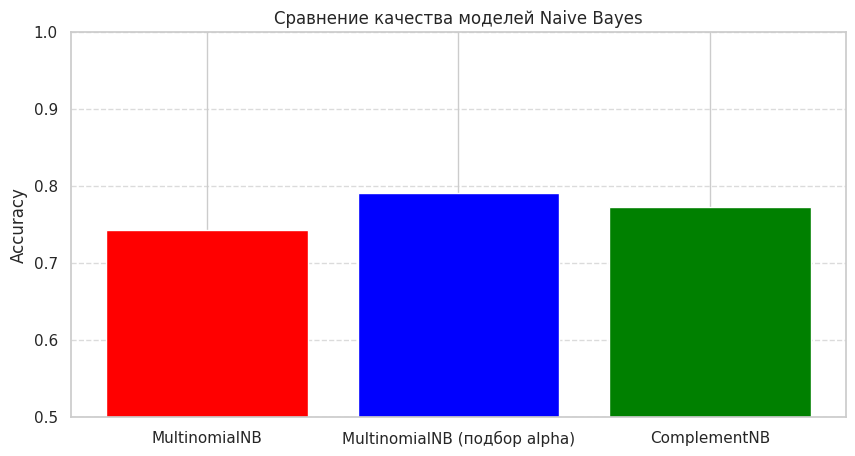

In [ ]:
import matplotlib.pyplot as plt

# Сравнение accuracy моделей семейства Naive Bayes
models_comparison = {
    'MultinomialNB': 0.7430,                    # старый базовый результат
    'MultinomialNB (подбор alpha)': accuracy_optimized_nb,
    'ComplementNB': accuracy_complement_nb
}

plt.figure(figsize=(10, 5))
plt.bar(models_comparison.keys(), models_comparison.values(), color=['red', 'blue', 'green'])
plt.title('Сравнение качества моделей Naive Bayes')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Используем уже подобранный alpha
optimized_nb = MultinomialNB(alpha=best_alpha)

# Калибровка SVM
calibrated_svc = CalibratedClassifierCV(LinearSVC(random_state=42))

# Ансамбль с улучшенным NB
ensemble_with_optimized_nb = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', calibrated_svc),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42)),
        ('cat', CatBoostClassifier(verbose=False, random_seed=42, task_type='GPU')),
        ('opt_nb', optimized_nb)
    ],
    voting='soft'
)

# Обучение ансамбля
ensemble_with_optimized_nb.fit(X_train, y_train)

# Прогноз и метрики
y_pred_ensemble_opt = ensemble_with_optimized_nb.predict(X_test)
accuracy_ensemble_opt = accuracy_score(y_test, y_pred_ensemble_opt)

print(f"Ensemble with Optimized NB accuracy: {accuracy_ensemble_opt:.4f}")
print(classification_report(y_test, y_pred_ensemble_opt))


Ensemble with Optimized NB accuracy: 0.9783
              precision    recall  f1-score   support

           0       1.00      0.78      0.87        40
           1       1.00      1.00      1.00       107
           2       0.96      1.00      0.98       149
           3       0.97      1.00      0.98       257
           4       0.98      0.99      0.99      1742
           5       0.98      0.96      0.97       163
           6       0.96      0.93      0.95       107
           7       0.98      0.85      0.91        54
           8       0.98      1.00      0.99       304
           9       1.00      1.00      1.00        39
          10       1.00      0.97      0.98        62
          11       0.98      1.00      0.99        92
          12       0.96      0.91      0.94       230
          13       0.96      0.94      0.95       109

    accuracy                           0.98      3455
   macro avg       0.98      0.95      0.96      3455
weighted avg       0.98      0.98   

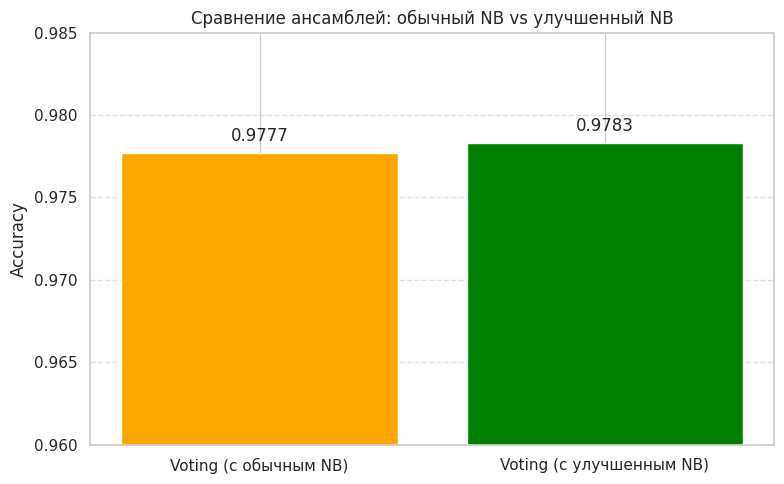

In [ ]:
import matplotlib.pyplot as plt


accuracy_old = 0.9777
accuracy_new = 0.9783
# Словарь моделей и их accuracy
ensemble_compare = {
    "Voting (с обычным NB)": accuracy_old,
    "Voting (с улучшенным NB)": accuracy_new
}

labels = list(ensemble_compare.keys())
scores = list(ensemble_compare.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, scores, color=['orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Сравнение ансамблей: обычный NB vs улучшенный NB')
plt.ylim(0.96, 0.985)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.0005,
             f"{height:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


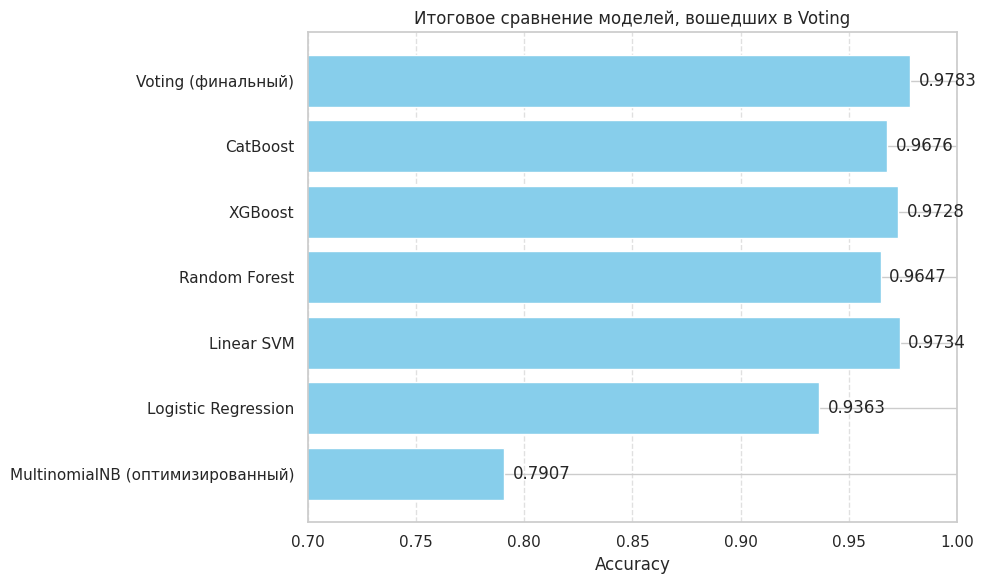

In [ ]:
# Accuracy всех моделей, вошедших в итоговый Voting
final_model_scores = {
    'MultinomialNB (оптимизированный)': 0.7907,
    'Logistic Regression': 0.9363,
    'Linear SVM': 0.9734,
    'Random Forest': 0.9647,
    'XGBoost': 0.9728,
    'CatBoost': 0.9676,
    'Voting (финальный)': 0.9783
}

# Построение графика
labels = list(final_model_scores.keys())
scores = list(final_model_scores.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Итоговое сравнение моделей, вошедших в Voting')


for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.004, bar.get_y() + bar.get_height() / 2,
             f"{width:.4f}", va='center')

plt.xlim(0.7, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
!pip install keybert
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

# Загрузка моделей
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
kw_model = KeyBERT(model=sbert_model)

# Список запрещённых подстрок в фразах
banned = [
    'occupation', 'occupied', 'russianoccupied',
    'zelda', 'spell', 'scraping', 'supercomputer',
    'starlinkconnected', 'datasets', 'eli'
]

# Словарь для результатов
cluster_names = {}

# Перебираем все уникальные кластеры
for cid in sorted(df_clean['cluster'].unique()):
    texts = df_clean[df_clean['cluster'] == cid]['clean_title']
    sample_n = min(400, len(texts))
    sample_texts = texts.sample(n=sample_n, random_state=42).tolist()
    joined = ' '.join(sample_texts)

    # Генерация ключевых фраз
    keywords = kw_model.extract_keywords(
        joined,
        keyphrase_ngram_range=(2, 3),
        top_n=5,
        stop_words='english',
        use_mmr=True,
        diversity=0.7
    )

    # Фильтрация и отбор
    candidates = [
        phrase for phrase, score in keywords
        if not any(bad in phrase.lower() for bad in banned)
        and len(phrase.split()) > 1
    ]
    cluster_names[cid] = candidates[:2]

# Вывод результата
for cid, names in cluster_names.items():
    print(f"Кластер {cid}:")
    if names:
        for i, name in enumerate(names, 1):
            print(f"  Вариант {i}: {name}")
    else:
        print("  Нет подходящих названий")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Кластер 0:
  Вариант 1: line lyric mentioning
  Вариант 2: record mot data
Кластер 1:
  Вариант 1: book quote book
  Вариант 2: week december reforming
Кластер 2:
  Вариант 1: gaming trend game
  Вариант 2: installation play instantly
Кластер 3:
  Вариант 1: trump tariff trump
  Вариант 2: musk rage judge
Кластер 4:
  Вариант 1: pirate select lsu
  Вариант 2: broke record pole
Кластер 5:
  Вариант 1: ukraine russian military
  Вариант 2: starmer say wont
Кластер 6:
  Вариант 1: hack whats socially
  Вариант 2: pain giving birth
Кластер 7:
  Вариант 1: disney animation studio
  Вариант 2: retirement advice travis
Кластер 8:
  Вариант 1: example walrus hippo
  Вариант 2: rate work people
Кластер 9:
  Вариант 1: star christopher nolans
  Вариант 2: femaledominated cast receive
Кластер 10:
  Вариант 1: surpasses michael phelps
  Вариант 2: rat penis transplant
Кластер 11:
  Вариант 1: say movie amazing
  Вариант 2: jon bernthal cast
Кластер 12:
  Вариант 1: harshly research suggests
  Вари

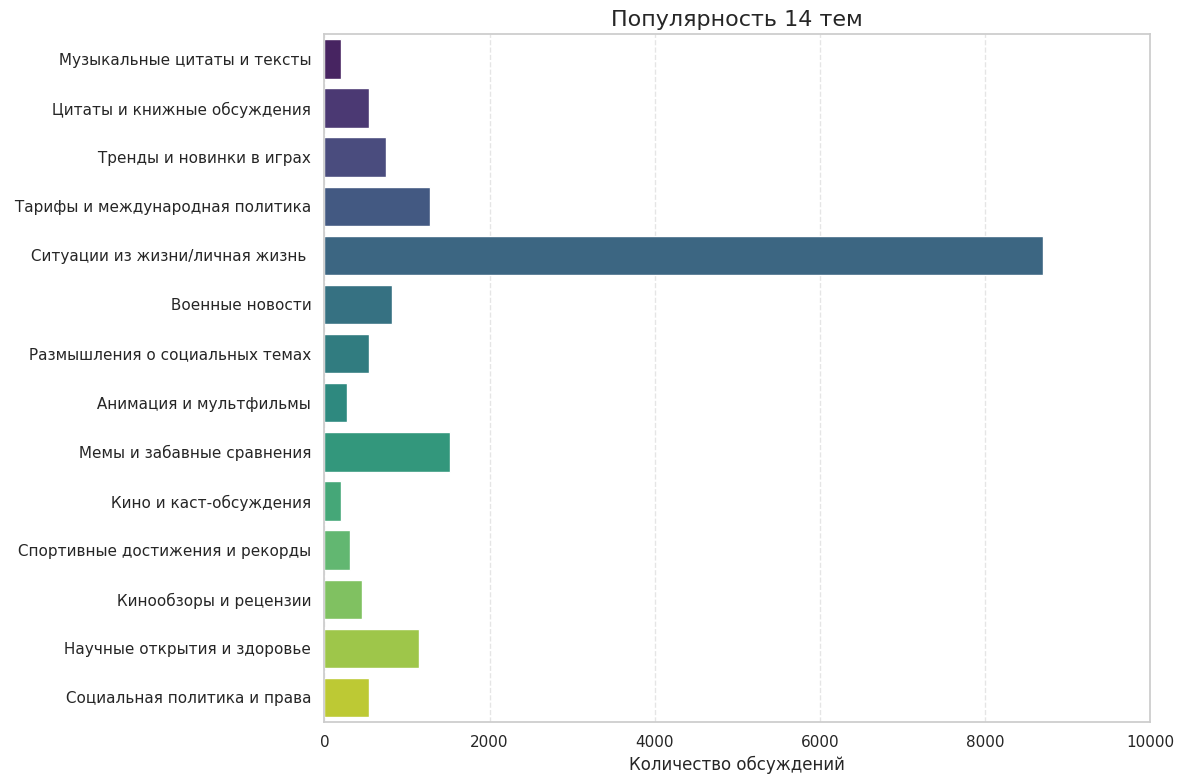

In [ ]:
# Финальные  названия для 14 кластеров
topic_labels = {
    0: " Музыкальные цитаты и тексты",
    1: " Цитаты и книжные обсуждения",
    2: " Тренды и новинки в играх",
    3: " Тарифы и международная политика",
    4: " Ситуации из жизни/личная жизнь ",
    5: " Военные новости",
    6: " Размышления о социальных темах",
    7: " Анимация и мультфильмы",
    8: " Мемы и забавные сравнения",
    9: " Кино и каст-обсуждения",
    10: " Спортивные достижения и рекорды",
    11: " Кинообзоры и рецензии",
    12: " Научные открытия и здоровье",
    13: " Социальная политика и права"
}

# Отсортируем по номеру кластера, чтобы подписи шли в нужном порядке
counts = df_clean['cluster'].value_counts().reindex(sorted(topic_labels.keys()))

# Собираем DataFrame для графика
df_plot = pd.DataFrame({
    'Название темы': [topic_labels[c] for c in counts.index],
    'Количество обсуждений': counts.values
})

# Рисуем горизонтальную диаграмму
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_plot,
    x='Количество обсуждений',
    y='Название темы',
    palette='viridis'
)
plt.title('Популярность 14 тем', fontsize=16)
plt.xlabel('Количество обсуждений')
plt.ylabel('')
plt.xlim(0, 10000)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()